In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/7cells_blurry"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    psf = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
from utils import *

/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

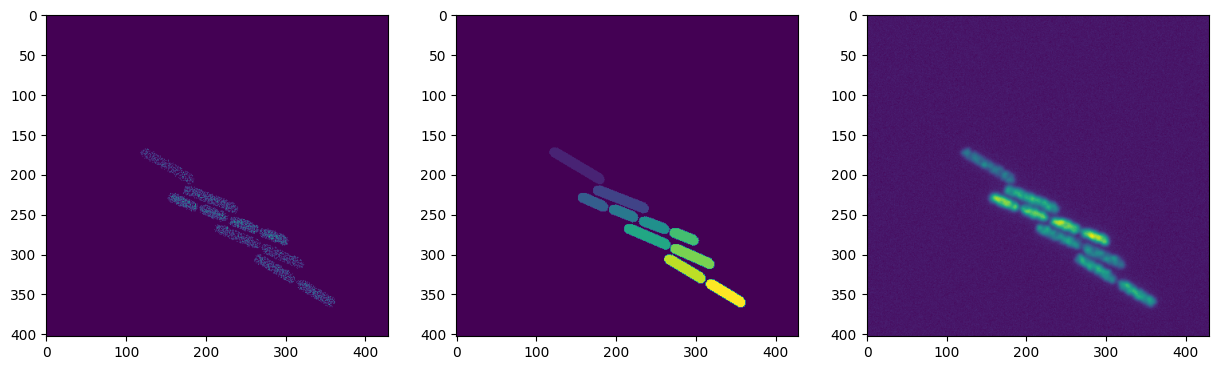

In [ ]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [ ]:
randomPts = 0
originalOutput = out
sourcePts = GetSourcePts(mask)
recoveredImage = InverseMatrix(out, mask, sourcePts, learningRate = 1, psf=psf)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[[0.47647935]
 [0.71049451]
 [0.94932142]
 [0.85486395]
 [0.96835668]
 [0.61617264]
 [1.        ]
 [0.54098628]
 [0.68322527]
 [0.71471411]]


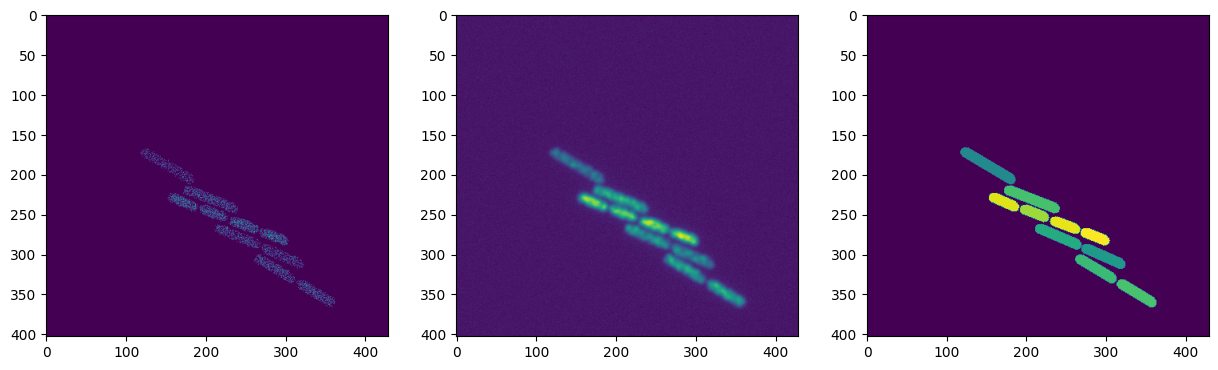

In [ ]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(out)
axarr[2].imshow(recoveredImage)
plt.show()

/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

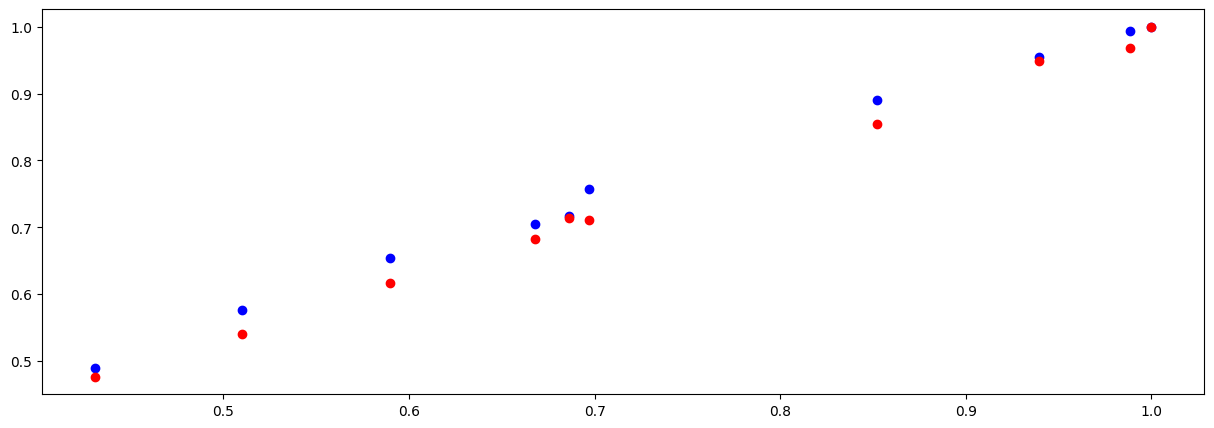

Default:  [[1.         0.99805942]
 [0.99805942 1.        ]]
Custom:  [[1.         0.99905839]
 [0.99905839 1.        ]]


In [ ]:
#Get average intensity in each mask

average_original_mask, average_original_intensity = GetAvgIntensityWithMask(ori,mask,sourcePts)
average_output_mask, average_output_intensity = GetAvgIntensityWithMask(out,mask,sourcePts)
average_custom_mask, average_custom_intensity = GetAvgIntensityWithMask(recoveredImage,mask,sourcePts)

assert(average_custom_intensity.all()==average_original_intensity.all())
assert(average_output_intensity.all()==average_original_intensity.all())

plt.plot(average_original_intensity,average_output_intensity,'bo')
plt.plot(average_original_intensity,average_custom_intensity,'ro')
plt.show()

#Calculate correlation coefficient
print("Default: ", np.corrcoef(average_original_intensity,average_output_intensity))
print("Custom: ", np.corrcoef(average_original_intensity,average_custom_intensity))

In [ ]:
print(out)

[[0.07330434 0.03820859 0.06260777 ... 0.0690013  0.06050202 0.04951553]
 [0.0721294  0.06863508 0.09401083 ... 0.04907301 0.05371176 0.06094453]
 [0.04682994 0.05400168 0.06483558 ... 0.05839628 0.04887465 0.0721294 ]
 ...
 [0.06095979 0.05368124 0.08253605 ... 0.06179904 0.06242466 0.07977417]
 [0.07881285 0.04592966 0.04982071 ... 0.05381857 0.05952544 0.08006409]
 [0.05157549 0.07035935 0.06199741 ... 0.06596475 0.07409781 0.09044022]]
